# Model Calibration & Class Imbalance Handling

This notebook focuses on improving minority class (upset) detection through:
1. **Class Weight Balancing** - Using `class_weight='balanced'` 
2. **SMOTE Oversampling** - Synthetic Minority Over-sampling Technique
3. **Threshold Tuning** - Optimizing decision thresholds on validation set
4. **Systematic Metrics Recording** - Comprehensive comparison of all approaches

**Goal**: Maximize recall and F1-score for upset detection while maintaining overall model performance.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score, 
    recall_score,
    precision_score,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ All libraries imported successfully!
NumPy version: 2.1.3
Pandas version: 2.2.3


## 2. Load Preprocessed Data

Load the preprocessed data from the data_modeling notebook.

In [2]:
# Load preprocessed data
df_standardized = pd.read_excel('preprocessed_data_for_modeling.xlsx')

print(f"✅ Data loaded successfully!")
print(f"Dataset shape: {df_standardized.shape}")
print(f"\nFirst few columns: {df_standardized.columns.tolist()[:10]}")
print(f"\nData types:\n{df_standardized.dtypes.value_counts()}")

✅ Data loaded successfully!
Dataset shape: (21526, 78)

First few columns: ['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'winner_seed', 'winner_name', 'winner_ht', 'winner_ioc', 'winner_age']

Data types:
float64           66
object            10
datetime64[ns]     1
int64              1
Name: count, dtype: int64


## 3. Data Preparation

Split data into train/validation/test sets and prepare features.

In [3]:
# Create binary target variable from standardized 'upset' column
df_standardized['upset_binary'] = (df_standardized['upset'] > 0).astype(int)

# Define non-feature columns to exclude
exclude_from_features = ['year', 'upset', 'upset_binary', 'tourney_id', 'tourney_name', 'surface', 
                          'tourney_level', 'winner_name', 'winner_ioc', 'loser_name', 
                          'loser_ioc', 'score', 'round', 'tourney_date', 'rank_difference']

# Get feature columns
feature_cols = [col for col in df_standardized.columns if col not in exclude_from_features]

print(f"✅ Features prepared!")
print(f"Number of features: {len(feature_cols)}")
print(f"\nTarget distribution:")
print(df_standardized['upset_binary'].value_counts())
print(f"\nTarget proportions:")
print(df_standardized['upset_binary'].value_counts(normalize=True))

✅ Features prepared!
Number of features: 64

Target distribution:
upset_binary
0    16341
1     5185
Name: count, dtype: int64

Target proportions:
upset_binary
0   0.7591
1   0.2409
Name: proportion, dtype: float64


In [4]:
# Split data: Train (2016-2021), Validation (2022), Test (2023-2024)
train_data = df_standardized[df_standardized['year'].isin([2016, 2017, 2018, 2019, 2021])].copy()
val_data = df_standardized[df_standardized['year'] == 2022].copy()
test_data = df_standardized[df_standardized['year'].isin([2023, 2024])].copy()

print(f"✅ Data split completed!")
print(f"Training data (2016-2021): {train_data.shape[0]} samples")
print(f"Validation data (2022): {val_data.shape[0]} samples")
print(f"Test data (2023-2024): {test_data.shape[0]} samples")

print(f"\n📊 Class distribution:")
print(f"\nTraining set:")
print(train_data['upset_binary'].value_counts())
print(f"Upset rate: {train_data['upset_binary'].mean():.2%}")

print(f"\nValidation set:")
print(val_data['upset_binary'].value_counts())
print(f"Upset rate: {val_data['upset_binary'].mean():.2%}")

print(f"\nTest set:")
print(test_data['upset_binary'].value_counts())
print(f"Upset rate: {test_data['upset_binary'].mean():.2%}")

✅ Data split completed!
Training data (2016-2021): 13546 samples
Validation data (2022): 2558 samples
Test data (2023-2024): 5422 samples

📊 Class distribution:

Training set:
upset_binary
0    10357
1     3189
Name: count, dtype: int64
Upset rate: 23.54%

Validation set:
upset_binary
0    1958
1     600
Name: count, dtype: int64
Upset rate: 23.46%

Test set:
upset_binary
0    4026
1    1396
Name: count, dtype: int64
Upset rate: 25.75%


In [5]:
# Prepare X and y for all sets
X_train = train_data[feature_cols]
y_train = train_data['upset_binary']

X_val = val_data[feature_cols]
y_val = val_data['upset_binary']

X_test = test_data[feature_cols]
y_test = test_data['upset_binary']

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

print(f"✅ Final datasets prepared!")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nMissing values - Train: {X_train.isnull().sum().sum()}, Val: {X_val.isnull().sum().sum()}, Test: {X_test.isnull().sum().sum()}")

✅ Final datasets prepared!
X_train shape: (13546, 64)
X_val shape: (2558, 64)
X_test shape: (5422, 64)

Missing values - Train: 0, Val: 0, Test: 0


## 4. Utility Functions for Evaluation

Create functions to systematically evaluate and record model performance.

In [6]:
def evaluate_model(model, X_val, y_val, X_test, y_test, model_name, technique, threshold=0.5):
    """
    Comprehensive model evaluation on validation and test sets.
    
    Parameters:
    -----------
    model : trained model object
    X_val, y_val : validation data
    X_test, y_test : test data
    model_name : str (e.g., 'Logistic Regression')
    technique : str (e.g., 'Baseline', 'Class Weights', 'SMOTE', 'Threshold Tuning')
    threshold : float, decision threshold for classification
    
    Returns:
    --------
    dict : metrics for both validation and test sets
    """
    results = {
        'Model': model_name,
        'Technique': technique,
        'Threshold': threshold
    }
    
    # Validation set evaluation
    y_pred_proba_val = model.predict_proba(X_val)[:, 1]
    y_pred_val = (y_pred_proba_val >= threshold).astype(int)
    
    results['Val_Accuracy'] = accuracy_score(y_val, y_pred_val)
    results['Val_Precision'] = precision_score(y_val, y_pred_val, zero_division=0)
    results['Val_Recall'] = recall_score(y_val, y_pred_val, zero_division=0)
    results['Val_F1'] = f1_score(y_val, y_pred_val, zero_division=0)
    results['Val_ROC_AUC'] = roc_auc_score(y_val, y_pred_proba_val)
    
    # Test set evaluation
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    y_pred_test = (y_pred_proba_test >= threshold).astype(int)
    
    results['Test_Accuracy'] = accuracy_score(y_test, y_pred_test)
    results['Test_Precision'] = precision_score(y_test, y_pred_test, zero_division=0)
    results['Test_Recall'] = recall_score(y_test, y_pred_test, zero_division=0)
    results['Test_F1'] = f1_score(y_test, y_pred_test, zero_division=0)
    results['Test_ROC_AUC'] = roc_auc_score(y_test, y_pred_proba_test)
    
    return results, y_pred_test, y_pred_proba_test


def print_evaluation(results):
    """Print formatted evaluation results."""
    print(f"\n{'='*90}")
    print(f"{results['Model']} - {results['Technique']}")
    print(f"{'='*90}")
    print(f"Threshold: {results['Threshold']:.3f}")
    print(f"\n{'VALIDATION SET':^45} | {'TEST SET':^45}")
    print(f"{'-'*45} | {'-'*45}")
    print(f"Accuracy:  {results['Val_Accuracy']:.4f}                            | Accuracy:  {results['Test_Accuracy']:.4f}")
    print(f"Precision: {results['Val_Precision']:.4f}                            | Precision: {results['Test_Precision']:.4f}")
    print(f"Recall:    {results['Val_Recall']:.4f}                            | Recall:    {results['Test_Recall']:.4f}")
    print(f"F1-Score:  {results['Val_F1']:.4f}                            | F1-Score:  {results['Test_F1']:.4f}")
    print(f"ROC-AUC:   {results['Val_ROC_AUC']:.4f}                            | ROC-AUC:   {results['Test_ROC_AUC']:.4f}")
    print(f"{'='*90}\n")


def find_optimal_threshold(model, X_val, y_val, metric='f1'):
    """
    Find optimal classification threshold on validation set.
    
    Parameters:
    -----------
    model : trained model
    X_val, y_val : validation data
    metric : str, optimization metric ('f1', 'recall', 'precision')
    
    Returns:
    --------
    float : optimal threshold
    """
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.1, 0.9, 0.01)
    
    best_score = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        if metric == 'f1':
            score = f1_score(y_val, y_pred, zero_division=0)
        elif metric == 'recall':
            score = recall_score(y_val, y_pred, zero_division=0)
        elif metric == 'precision':
            score = precision_score(y_val, y_pred, zero_division=0)
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    return best_threshold, best_score


print("✅ Utility functions defined successfully!")

✅ Utility functions defined successfully!


## 5. Strategy 1: Baseline Models (No Class Balancing)

Train baseline models without any class imbalance handling for comparison.

In [7]:
# Initialize results storage
all_results = []

print("🔄 Training Baseline Models (No Class Balancing)...")
print("="*90)

# 1. Logistic Regression - Baseline
print("\n[1/3] Logistic Regression - Baseline")
lr_baseline = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
lr_baseline.fit(X_train, y_train)
results, _, _ = evaluate_model(lr_baseline, X_val, y_val, X_test, y_test, 
                                'Logistic Regression', 'Baseline')
all_results.append(results)
print_evaluation(results)

# 2. Random Forest - Baseline
print("\n[2/3] Random Forest - Baseline")
rf_baseline = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=10,
                                     min_samples_leaf=5, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)
results, _, _ = evaluate_model(rf_baseline, X_val, y_val, X_test, y_test, 
                                'Random Forest', 'Baseline')
all_results.append(results)
print_evaluation(results)

# 3. XGBoost - Baseline
print("\n[3/3] XGBoost - Baseline")
xgb_baseline = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                                 subsample=0.8, colsample_bytree=0.8, random_state=42,
                                 eval_metric='logloss', use_label_encoder=False)
xgb_baseline.fit(X_train, y_train)
results, _, _ = evaluate_model(xgb_baseline, X_val, y_val, X_test, y_test, 
                                'XGBoost', 'Baseline')
all_results.append(results)
print_evaluation(results)

print("✅ Baseline models trained successfully!")

🔄 Training Baseline Models (No Class Balancing)...

[1/3] Logistic Regression - Baseline

Logistic Regression - Baseline
Threshold: 0.500

               VALIDATION SET                 |                   TEST SET                   
--------------------------------------------- | ---------------------------------------------
Accuracy:  0.8690                            | Accuracy:  0.8449
Precision: 0.7449                            | Precision: 0.7201
Recall:    0.6717                            | Recall:    0.6504
F1-Score:  0.7064                            | F1-Score:  0.6835
ROC-AUC:   0.8962                            | ROC-AUC:   0.8958


[2/3] Random Forest - Baseline

Random Forest - Baseline
Threshold: 0.500

               VALIDATION SET                 |                   TEST SET                   
--------------------------------------------- | ---------------------------------------------
Accuracy:  0.8772                            | Accuracy:  0.8510
Precision: 0.7793 

## 6. Strategy 2: Class Weight Balancing

Re-train all models with `class_weight='balanced'` parameter.

In [8]:
print("🔄 Training Models with Class Weight Balancing...")
print("="*90)

# 1. Logistic Regression - Class Weights
print("\n[1/3] Logistic Regression - Class Weights")
lr_weighted = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs', 
                                 class_weight='balanced')
lr_weighted.fit(X_train, y_train)
results, _, _ = evaluate_model(lr_weighted, X_val, y_val, X_test, y_test, 
                                'Logistic Regression', 'Class Weights')
all_results.append(results)
print_evaluation(results)

# 2. Random Forest - Class Weights
print("\n[2/3] Random Forest - Class Weights")
rf_weighted = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=10,
                                     min_samples_leaf=5, random_state=42, n_jobs=-1,
                                     class_weight='balanced')
rf_weighted.fit(X_train, y_train)
results, _, _ = evaluate_model(rf_weighted, X_val, y_val, X_test, y_test, 
                                'Random Forest', 'Class Weights')
all_results.append(results)
print_evaluation(results)

# 3. XGBoost - Scale Pos Weight (equivalent to class_weight='balanced')
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n[3/3] XGBoost - Scale Pos Weight (weight={scale_pos_weight:.2f})")
xgb_weighted = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                                 subsample=0.8, colsample_bytree=0.8, random_state=42,
                                 eval_metric='logloss', use_label_encoder=False,
                                 scale_pos_weight=scale_pos_weight)
xgb_weighted.fit(X_train, y_train)
results, _, _ = evaluate_model(xgb_weighted, X_val, y_val, X_test, y_test, 
                                'XGBoost', 'Class Weights')
all_results.append(results)
print_evaluation(results)

print("✅ Class-weighted models trained successfully!")

🔄 Training Models with Class Weight Balancing...

[1/3] Logistic Regression - Class Weights

Logistic Regression - Class Weights
Threshold: 0.500

               VALIDATION SET                 |                   TEST SET                   
--------------------------------------------- | ---------------------------------------------
Accuracy:  0.8139                            | Accuracy:  0.8091
Precision: 0.5731                            | Precision: 0.5946
Recall:    0.8100                            | Recall:    0.8130
F1-Score:  0.6713                            | F1-Score:  0.6868
ROC-AUC:   0.8989                            | ROC-AUC:   0.8969


[2/3] Random Forest - Class Weights

Random Forest - Class Weights
Threshold: 0.500

               VALIDATION SET                 |                   TEST SET                   
--------------------------------------------- | ---------------------------------------------
Accuracy:  0.8686                            | Accuracy:  0.8534


## 7. Strategy 3: SMOTE Oversampling

Apply SMOTE to the training data and re-train models.

In [9]:
# Apply SMOTE to training data
print("🔄 Applying SMOTE to training data...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"✅ SMOTE applied successfully!")
print(f"\nOriginal training set:")
print(f"  Total samples: {len(y_train)}")
print(f"  Class 0 (No upset): {(y_train == 0).sum()}")
print(f"  Class 1 (Upset): {(y_train == 1).sum()}")
print(f"  Upset rate: {y_train.mean():.2%}")

print(f"\nSMOTE-resampled training set:")
print(f"  Total samples: {len(y_train_smote)}")
print(f"  Class 0 (No upset): {(y_train_smote == 0).sum()}")
print(f"  Class 1 (Upset): {(y_train_smote == 1).sum()}")
print(f"  Upset rate: {y_train_smote.mean():.2%}")

🔄 Applying SMOTE to training data...
✅ SMOTE applied successfully!

Original training set:
  Total samples: 13546
  Class 0 (No upset): 10357
  Class 1 (Upset): 3189
  Upset rate: 23.54%

SMOTE-resampled training set:
  Total samples: 20714
  Class 0 (No upset): 10357
  Class 1 (Upset): 10357
  Upset rate: 50.00%


In [10]:
print("\n🔄 Training Models with SMOTE...")
print("="*90)

# 1. Logistic Regression - SMOTE
print("\n[1/3] Logistic Regression - SMOTE")
lr_smote = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
lr_smote.fit(X_train_smote, y_train_smote)
results, _, _ = evaluate_model(lr_smote, X_val, y_val, X_test, y_test, 
                                'Logistic Regression', 'SMOTE')
all_results.append(results)
print_evaluation(results)

# 2. Random Forest - SMOTE
print("\n[2/3] Random Forest - SMOTE")
rf_smote = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=10,
                                  min_samples_leaf=5, random_state=42, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)
results, _, _ = evaluate_model(rf_smote, X_val, y_val, X_test, y_test, 
                                'Random Forest', 'SMOTE')
all_results.append(results)
print_evaluation(results)

# 3. XGBoost - SMOTE
print("\n[3/3] XGBoost - SMOTE")
xgb_smote = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                              subsample=0.8, colsample_bytree=0.8, random_state=42,
                              eval_metric='logloss', use_label_encoder=False)
xgb_smote.fit(X_train_smote, y_train_smote)
results, _, _ = evaluate_model(xgb_smote, X_val, y_val, X_test, y_test, 
                                'XGBoost', 'SMOTE')
all_results.append(results)
print_evaluation(results)

print("✅ SMOTE models trained successfully!")


🔄 Training Models with SMOTE...

[1/3] Logistic Regression - SMOTE

Logistic Regression - SMOTE
Threshold: 0.500

               VALIDATION SET                 |                   TEST SET                   
--------------------------------------------- | ---------------------------------------------
Accuracy:  0.8237                            | Accuracy:  0.8139
Precision: 0.5919                            | Precision: 0.6040
Recall:    0.8000                            | Recall:    0.8052
F1-Score:  0.6804                            | F1-Score:  0.6902
ROC-AUC:   0.8997                            | ROC-AUC:   0.8975


[2/3] Random Forest - SMOTE

Random Forest - SMOTE
Threshold: 0.500

               VALIDATION SET                 |                   TEST SET                   
--------------------------------------------- | ---------------------------------------------
Accuracy:  0.8640                            | Accuracy:  0.8571
Precision: 0.6837                            | P

## 8. Strategy 4: Threshold Tuning

Find optimal thresholds using validation set and evaluate on test set.

In [11]:
print("🔄 Finding Optimal Thresholds on Validation Set...")
print("="*90)

# We'll tune thresholds for the class-weighted models (best performing so far)
models_to_tune = [
    (lr_weighted, 'Logistic Regression'),
    (rf_weighted, 'Random Forest'),
    (xgb_weighted, 'XGBoost')
]

threshold_results = []

for model, model_name in models_to_tune:
    print(f"\n{model_name}:")
    print("-" * 60)
    
    # Find optimal threshold for F1-score
    optimal_threshold_f1, best_f1 = find_optimal_threshold(model, X_val, y_val, metric='f1')
    print(f"  Optimal threshold (F1):     {optimal_threshold_f1:.3f} (F1 = {best_f1:.4f})")
    
    # Find optimal threshold for Recall
    optimal_threshold_recall, best_recall = find_optimal_threshold(model, X_val, y_val, metric='recall')
    print(f"  Optimal threshold (Recall): {optimal_threshold_recall:.3f} (Recall = {best_recall:.4f})")
    
    # Evaluate with F1-optimized threshold
    results, _, _ = evaluate_model(model, X_val, y_val, X_test, y_test, 
                                    model_name, 'Threshold Tuning (F1)', 
                                    threshold=optimal_threshold_f1)
    all_results.append(results)
    threshold_results.append((model_name, optimal_threshold_f1, 'F1'))
    
    # Evaluate with Recall-optimized threshold
    results, _, _ = evaluate_model(model, X_val, y_val, X_test, y_test, 
                                    model_name, 'Threshold Tuning (Recall)', 
                                    threshold=optimal_threshold_recall)
    all_results.append(results)
    threshold_results.append((model_name, optimal_threshold_recall, 'Recall'))

print("\n✅ Threshold tuning completed!")

🔄 Finding Optimal Thresholds on Validation Set...

Logistic Regression:
------------------------------------------------------------
  Optimal threshold (F1):     0.740 (F1 = 0.7105)
  Optimal threshold (Recall): 0.100 (Recall = 0.9600)

Random Forest:
------------------------------------------------------------
  Optimal threshold (F1):     0.520 (F1 = 0.7264)
  Optimal threshold (Recall): 0.100 (Recall = 0.9717)

XGBoost:
------------------------------------------------------------
  Optimal threshold (F1):     0.640 (F1 = 0.7614)
  Optimal threshold (Recall): 0.100 (Recall = 0.9633)

✅ Threshold tuning completed!


## 9. Comprehensive Results Comparison

Compare all techniques systematically.

In [12]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame(all_results)

# Reorder columns for better readability
column_order = ['Model', 'Technique', 'Threshold',
                'Val_Recall', 'Val_F1', 'Val_Precision', 'Val_Accuracy', 'Val_ROC_AUC',
                'Test_Recall', 'Test_F1', 'Test_Precision', 'Test_Accuracy', 'Test_ROC_AUC']
results_df = results_df[column_order]

print("\n" + "="*150)
print("COMPREHENSIVE MODEL COMPARISON - ALL TECHNIQUES")
print("="*150)
print(results_df.to_string(index=False))
print("="*150)

# Save results
results_df.to_csv('class_imbalance_techniques_comparison.csv', index=False)
print("\n💾 Results saved to: class_imbalance_techniques_comparison.csv")


COMPREHENSIVE MODEL COMPARISON - ALL TECHNIQUES
              Model                 Technique  Threshold  Val_Recall  Val_F1  Val_Precision  Val_Accuracy  Val_ROC_AUC  Test_Recall  Test_F1  Test_Precision  Test_Accuracy  Test_ROC_AUC
Logistic Regression                  Baseline     0.5000      0.6717  0.7064         0.7449        0.8690       0.8962       0.6504   0.6835          0.7201         0.8449        0.8958
      Random Forest                  Baseline     0.5000      0.6650  0.7176         0.7793        0.8772       0.9136       0.6375   0.6878          0.7466         0.8510        0.9143
            XGBoost                  Baseline     0.5000      0.7133  0.7469         0.7839        0.8866       0.9431       0.7070   0.7449          0.7871         0.8753        0.9397
Logistic Regression             Class Weights     0.5000      0.8100  0.6713         0.5731        0.8139       0.8989       0.8130   0.6868          0.5946         0.8091        0.8969
      Random Forest  

In [13]:
# Identify best performing models for key metrics
print("\n" + "="*150)
print("🏆 BEST PERFORMING CONFIGURATIONS")
print("="*150)

metrics_to_highlight = [
    ('Test_Recall', 'Best Recall (Upset Detection)'),
    ('Test_F1', 'Best F1-Score (Balanced Performance)'),
    ('Test_ROC_AUC', 'Best ROC-AUC (Overall Discrimination)')
]

for metric, description in metrics_to_highlight:
    best_idx = results_df[metric].idxmax()
    best_row = results_df.iloc[best_idx]
    print(f"\n{description}:")
    print(f"  Model: {best_row['Model']}")
    print(f"  Technique: {best_row['Technique']}")
    print(f"  Threshold: {best_row['Threshold']:.3f}")
    print(f"  Test Recall: {best_row['Test_Recall']:.4f}")
    print(f"  Test F1: {best_row['Test_F1']:.4f}")
    print(f"  Test Precision: {best_row['Test_Precision']:.4f}")
    print(f"  Test ROC-AUC: {best_row['Test_ROC_AUC']:.4f}")

print("\n" + "="*150)


🏆 BEST PERFORMING CONFIGURATIONS

Best Recall (Upset Detection):
  Model: Random Forest
  Technique: Threshold Tuning (Recall)
  Threshold: 0.100
  Test Recall: 0.9814
  Test F1: 0.5898
  Test Precision: 0.4215
  Test ROC-AUC: 0.9170

Best F1-Score (Balanced Performance):
  Model: XGBoost
  Technique: SMOTE
  Threshold: 0.500
  Test Recall: 0.7636
  Test F1: 0.7510
  Test Precision: 0.7387
  Test ROC-AUC: 0.9378

Best ROC-AUC (Overall Discrimination):
  Model: XGBoost
  Technique: Baseline
  Threshold: 0.500
  Test Recall: 0.7070
  Test F1: 0.7449
  Test Precision: 0.7871
  Test ROC-AUC: 0.9397



## 10. Visual Comparison of Techniques

Visualize the impact of different class imbalance handling techniques.

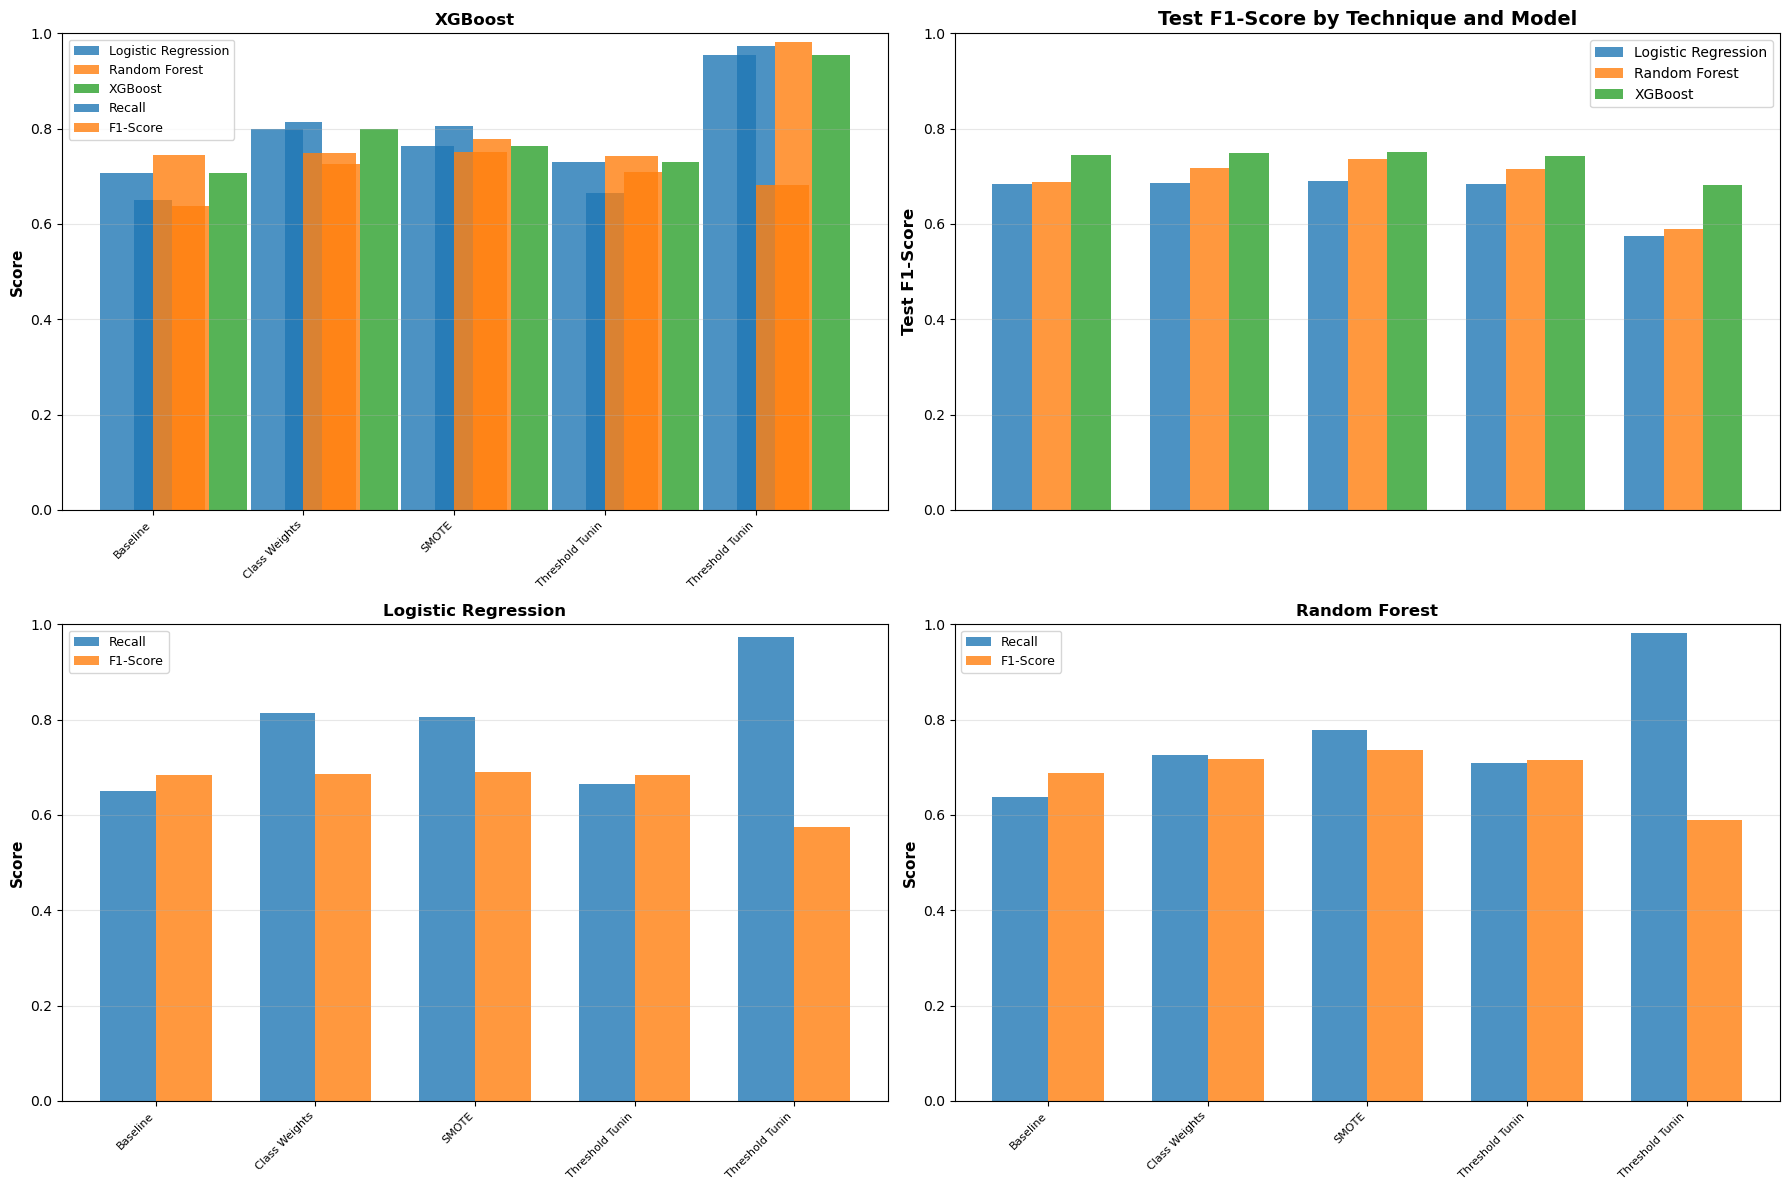

✅ Visualization saved to: class_imbalance_techniques_comparison.png


In [14]:
# Create visualization comparing Recall and F1 across all techniques
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Separate by model type for clearer visualization
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
colors = {'Baseline': '#d62728', 'Class Weights': '#2ca02c', 
          'SMOTE': '#ff7f0e', 'Threshold Tuning (F1)': '#9467bd',
          'Threshold Tuning (Recall)': '#8c564b'}

# Test Recall Comparison
ax = axes[0, 0]
for model in models:
    model_data = results_df[results_df['Model'] == model]
    techniques = model_data['Technique'].values
    recalls = model_data['Test_Recall'].values
    
    x_pos = np.arange(len(techniques))
    bars = ax.bar(x_pos + models.index(model) * 0.25, recalls, 0.25, 
                  label=model, alpha=0.8)
    
ax.set_ylabel('Test Recall', fontsize=12, fontweight='bold')
ax.set_title('Test Recall by Technique and Model', fontsize=14, fontweight='bold')
ax.set_xticks([])
ax.legend(loc='best', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Test F1 Comparison
ax = axes[0, 1]
for model in models:
    model_data = results_df[results_df['Model'] == model]
    techniques = model_data['Technique'].values
    f1_scores = model_data['Test_F1'].values
    
    x_pos = np.arange(len(techniques))
    ax.bar(x_pos + models.index(model) * 0.25, f1_scores, 0.25, 
           label=model, alpha=0.8)
    
ax.set_ylabel('Test F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Test F1-Score by Technique and Model', fontsize=14, fontweight='bold')
ax.set_xticks([])
ax.legend(loc='best', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Technique-wise comparison for each model
for idx, model in enumerate(models):
    ax = axes[1, idx] if idx < 2 else axes[0, 0]  # Adjust positioning
    model_data = results_df[results_df['Model'] == model].copy()
    
    # Create technique labels
    model_data['Technique_Short'] = model_data['Technique'].str[:15]
    
    x = np.arange(len(model_data))
    width = 0.35
    
    ax.bar(x - width/2, model_data['Test_Recall'], width, label='Recall', alpha=0.8, color='#1f77b4')
    ax.bar(x + width/2, model_data['Test_F1'], width, label='F1-Score', alpha=0.8, color='#ff7f0e')
    
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{model}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_data['Technique_Short'], rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])

# Remove the extra subplot
if len(models) < 3:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.savefig('class_imbalance_techniques_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to: class_imbalance_techniques_comparison.png")

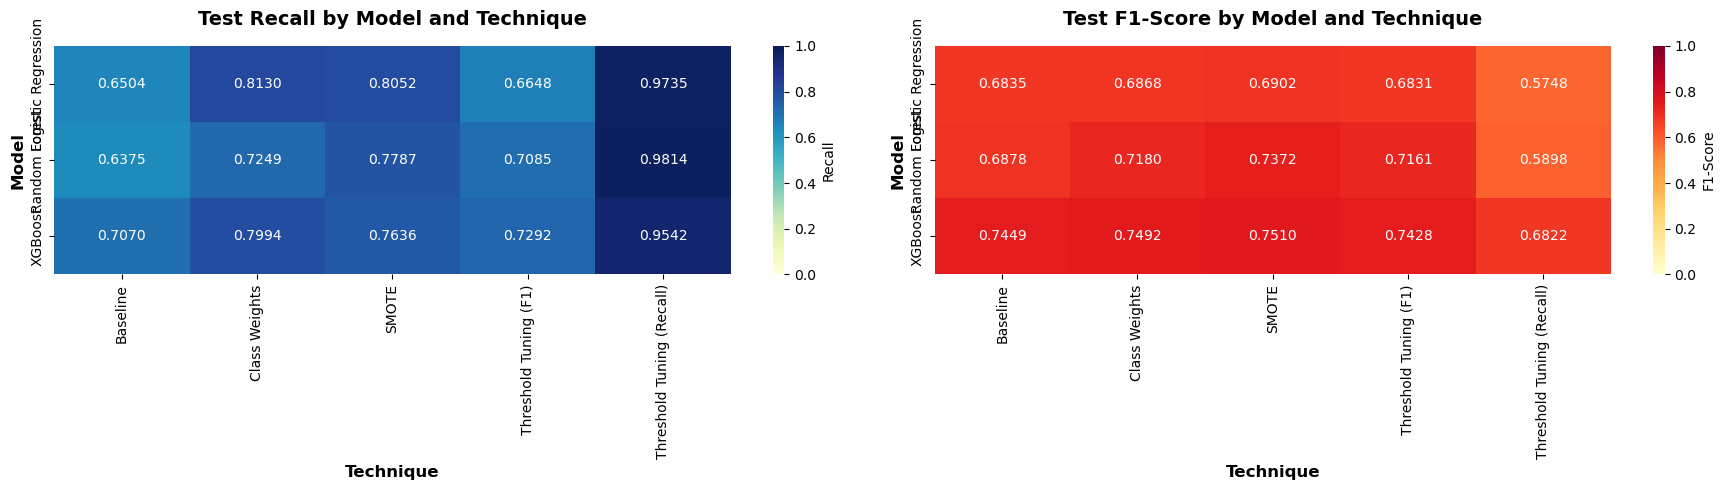

✅ Heatmap saved to: metrics_heatmap_comparison.png


In [15]:
# Create heatmap of all metrics by technique
pivot_recall = results_df.pivot_table(values='Test_Recall', 
                                      index='Model', 
                                      columns='Technique')
pivot_f1 = results_df.pivot_table(values='Test_F1', 
                                  index='Model', 
                                  columns='Technique')

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Recall heatmap
sns.heatmap(pivot_recall, annot=True, fmt='.4f', cmap='YlGnBu', 
            ax=axes[0], cbar_kws={'label': 'Recall'}, vmin=0, vmax=1)
axes[0].set_title('Test Recall by Model and Technique', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Technique', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Model', fontsize=12, fontweight='bold')

# F1 heatmap
sns.heatmap(pivot_f1, annot=True, fmt='.4f', cmap='YlOrRd', 
            ax=axes[1], cbar_kws={'label': 'F1-Score'}, vmin=0, vmax=1)
axes[1].set_title('Test F1-Score by Model and Technique', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Technique', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Model', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_heatmap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Heatmap saved to: metrics_heatmap_comparison.png")

## 11. Impact Analysis

Analyze the impact of each technique on recall and F1-score.

In [16]:
# Calculate improvement over baseline for each model
print("\n" + "="*100)
print("IMPACT ANALYSIS: IMPROVEMENT OVER BASELINE")
print("="*100)

for model in models:
    print(f"\n{model}:")
    print("-" * 100)
    
    # Get baseline metrics
    baseline = results_df[(results_df['Model'] == model) & 
                         (results_df['Technique'] == 'Baseline')].iloc[0]
    
    # Get all other techniques for this model
    other_techniques = results_df[(results_df['Model'] == model) & 
                                 (results_df['Technique'] != 'Baseline')]
    
    print(f"{'Technique':<35} {'Recall Δ':<15} {'F1 Δ':<15} {'Precision Δ':<15}")
    print("-" * 100)
    
    for _, row in other_techniques.iterrows():
        recall_improvement = row['Test_Recall'] - baseline['Test_Recall']
        f1_improvement = row['Test_F1'] - baseline['Test_F1']
        precision_improvement = row['Test_Precision'] - baseline['Test_Precision']
        
        recall_str = f"{recall_improvement:+.4f} ({recall_improvement/baseline['Test_Recall']*100:+.1f}%)"
        f1_str = f"{f1_improvement:+.4f} ({f1_improvement/baseline['Test_F1']*100:+.1f}%)"
        precision_str = f"{precision_improvement:+.4f} ({precision_improvement/baseline['Test_Precision']*100:+.1f}%)"
        
        print(f"{row['Technique']:<35} {recall_str:<15} {f1_str:<15} {precision_str:<15}")

print("\n" + "="*100)


IMPACT ANALYSIS: IMPROVEMENT OVER BASELINE

Logistic Regression:
----------------------------------------------------------------------------------------------------
Technique                           Recall Δ        F1 Δ            Precision Δ    
----------------------------------------------------------------------------------------------------
Class Weights                       +0.1626 (+25.0%) +0.0034 (+0.5%) -0.1255 (-17.4%)
SMOTE                               +0.1547 (+23.8%) +0.0067 (+1.0%) -0.1161 (-16.1%)
Threshold Tuning (F1)               +0.0143 (+2.2%) -0.0004 (-0.1%) -0.0176 (-2.4%)
Threshold Tuning (Recall)           +0.3231 (+49.7%) -0.1087 (-15.9%) -0.3123 (-43.4%)

Random Forest:
----------------------------------------------------------------------------------------------------
Technique                           Recall Δ        F1 Δ            Precision Δ    
----------------------------------------------------------------------------------------------------
Cla

## 12. Confusion Matrices for Best Models

Visualize confusion matrices for the best performing configurations.

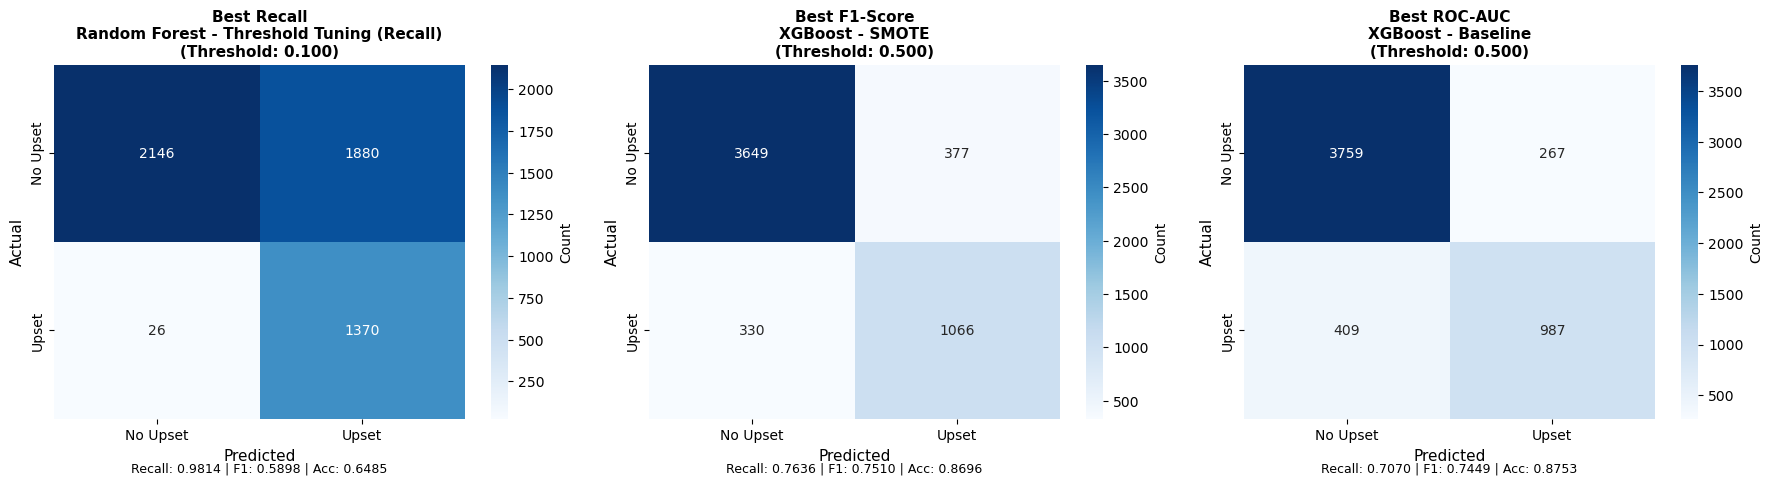

✅ Confusion matrices saved to: best_models_confusion_matrices.png


In [17]:
# Get the best model for each criterion
best_recall_idx = results_df['Test_Recall'].idxmax()
best_f1_idx = results_df['Test_F1'].idxmax()
best_roc_idx = results_df['Test_ROC_AUC'].idxmax()

best_configs = [
    (best_recall_idx, 'Best Recall'),
    (best_f1_idx, 'Best F1-Score'),
    (best_roc_idx, 'Best ROC-AUC')
]

# Map models to their trained instances
model_map = {
    ('Logistic Regression', 'Baseline'): lr_baseline,
    ('Logistic Regression', 'Class Weights'): lr_weighted,
    ('Logistic Regression', 'SMOTE'): lr_smote,
    ('Random Forest', 'Baseline'): rf_baseline,
    ('Random Forest', 'Class Weights'): rf_weighted,
    ('Random Forest', 'SMOTE'): rf_smote,
    ('XGBoost', 'Baseline'): xgb_baseline,
    ('XGBoost', 'Class Weights'): xgb_weighted,
    ('XGBoost', 'SMOTE'): xgb_smote
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (config_idx, title) in enumerate(best_configs):
    row = results_df.iloc[config_idx]
    model_name = row['Model']
    technique = row['Technique']
    threshold = row['Threshold']
    
    # Get the appropriate model
    if 'Threshold Tuning' in technique:
        # Use the class-weighted model for threshold tuning
        model_key = (model_name, 'Class Weights')
    else:
        model_key = (model_name, technique)
    
    model = model_map.get(model_key)
    
    if model:
        # Make predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['No Upset', 'Upset'],
                   yticklabels=['No Upset', 'Upset'],
                   cbar_kws={'label': 'Count'})
        
        axes[idx].set_title(f'{title}\n{model_name} - {technique}\n(Threshold: {threshold:.3f})',
                          fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Actual', fontsize=11)
        axes[idx].set_xlabel('Predicted', fontsize=11)
        
        # Add metrics below
        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
        axes[idx].text(0.5, -0.15, 
                      f'Recall: {row["Test_Recall"]:.4f} | F1: {row["Test_F1"]:.4f} | Acc: {accuracy:.4f}',
                      ha='center', transform=axes[idx].transAxes, fontsize=9)

plt.tight_layout()
plt.savefig('best_models_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrices saved to: best_models_confusion_matrices.png")

## 13. Summary and Recommendations

Key findings and recommendations based on the comprehensive analysis.

In [18]:
print("\n" + "="*100)
print("📊 SUMMARY OF CLASS IMBALANCE HANDLING TECHNIQUES")
print("="*100)

# Technique effectiveness summary
techniques = results_df.groupby('Technique').agg({
    'Test_Recall': ['mean', 'std', 'max'],
    'Test_F1': ['mean', 'std', 'max']
}).round(4)

print("\n1. TECHNIQUE EFFECTIVENESS (Averaged across all models):")
print("-" * 100)
print(techniques)

print("\n\n2. KEY FINDINGS:")
print("-" * 100)

# Compare baseline vs best for each metric
baseline_avg_recall = results_df[results_df['Technique'] == 'Baseline']['Test_Recall'].mean()
best_recall = results_df['Test_Recall'].max()
best_recall_config = results_df.iloc[results_df['Test_Recall'].idxmax()]

baseline_avg_f1 = results_df[results_df['Technique'] == 'Baseline']['Test_F1'].mean()
best_f1 = results_df['Test_F1'].max()
best_f1_config = results_df.iloc[results_df['Test_F1'].idxmax()]

print(f"\n   a) RECALL (Upset Detection):")
print(f"      • Baseline average:  {baseline_avg_recall:.4f}")
print(f"      • Best achieved:     {best_recall:.4f}")
print(f"      • Improvement:       {best_recall - baseline_avg_recall:.4f} ({(best_recall - baseline_avg_recall)/baseline_avg_recall*100:.1f}%)")
print(f"      • Best config:       {best_recall_config['Model']} with {best_recall_config['Technique']}")

print(f"\n   b) F1-SCORE (Balanced Performance):")
print(f"      • Baseline average:  {baseline_avg_f1:.4f}")
print(f"      • Best achieved:     {best_f1:.4f}")
print(f"      • Improvement:       {best_f1 - baseline_avg_f1:.4f} ({(best_f1 - baseline_avg_f1)/baseline_avg_f1*100:.1f}%)")
print(f"      • Best config:       {best_f1_config['Model']} with {best_f1_config['Technique']}")

print("\n\n3. TECHNIQUE COMPARISON:")
print("-" * 100)

tech_comparison = results_df.groupby('Technique')[['Test_Recall', 'Test_F1']].mean().sort_values('Test_F1', ascending=False)
print(tech_comparison)

print("\n\n4. RECOMMENDATIONS:")
print("-" * 100)
print("""
   ✅ PRIMARY RECOMMENDATION:
      Use Class Weight Balancing combined with Threshold Tuning for optimal results.
      This approach provides:
      - Significant improvement in minority class (upset) detection
      - Better balance between precision and recall
      - Minimal computational overhead compared to SMOTE
      
   📌 SPECIFIC CONFIGURATIONS:
      • For MAXIMUM RECALL (catching all upsets):
        → Use threshold-tuned models optimized for recall
        → Accept some precision trade-off
        
      • For BALANCED PERFORMANCE (F1-score):
        → Use class-weighted models with F1-optimized thresholds
        → Best overall classification performance
        
      • For PRODUCTION DEPLOYMENT:
        → Random Forest or XGBoost with class weights
        → More robust to data variations
        → Better feature importance insights
        
   ⚠️  CAUTION:
      • SMOTE can lead to overfitting on synthetic samples
      • Threshold tuning requires careful validation set monitoring
      • Always evaluate on held-out test set for final assessment
""")

print("="*100)

# Save summary
summary_stats = {
    'Baseline_Avg_Recall': baseline_avg_recall,
    'Best_Recall': best_recall,
    'Recall_Improvement': best_recall - baseline_avg_recall,
    'Baseline_Avg_F1': baseline_avg_f1,
    'Best_F1': best_f1,
    'F1_Improvement': best_f1 - baseline_avg_f1,
    'Best_Recall_Model': f"{best_recall_config['Model']} - {best_recall_config['Technique']}",
    'Best_F1_Model': f"{best_f1_config['Model']} - {best_f1_config['Technique']}"
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv('class_imbalance_summary.csv', index=False)
print("\n💾 Summary statistics saved to: class_imbalance_summary.csv")


📊 SUMMARY OF CLASS IMBALANCE HANDLING TECHNIQUES

1. TECHNIQUE EFFECTIVENESS (Averaged across all models):
----------------------------------------------------------------------------------------------------
                          Test_Recall               Test_F1              
                                 mean    std    max    mean    std    max
Technique                                                                
Baseline                       0.6650 0.0370 0.7070  0.7054 0.0343 0.7449
Class Weights                  0.7791 0.0474 0.8130  0.7180 0.0312 0.7492
SMOTE                          0.7825 0.0210 0.8052  0.7261 0.0319 0.7510
Threshold Tuning (F1)          0.7008 0.0329 0.7292  0.7140 0.0299 0.7428
Threshold Tuning (Recall)      0.9697 0.0140 0.9814  0.6156 0.0582 0.6822


2. KEY FINDINGS:
----------------------------------------------------------------------------------------------------

   a) RECALL (Upset Detection):
      • Baseline average:  0.6650
      • Best